In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

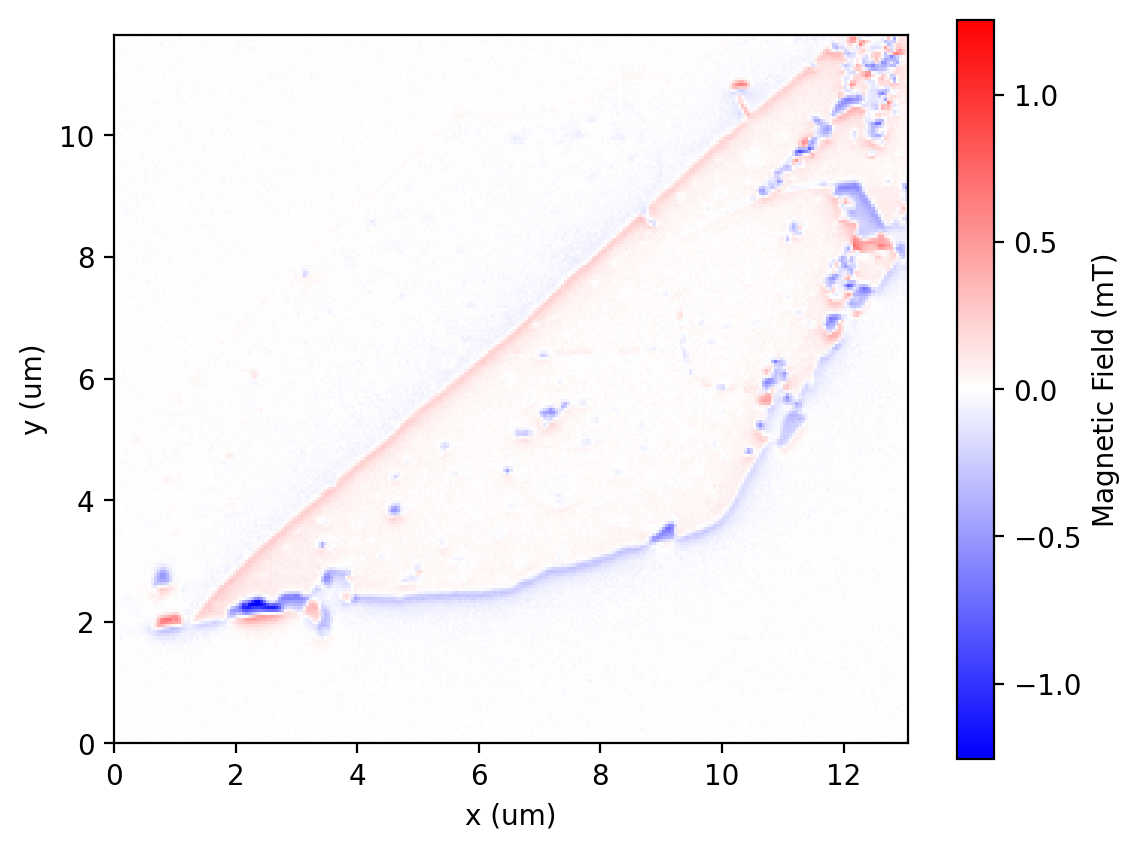

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

height =  0.05 # in um


# Create a data class
dataset = Data()
# Load the data to the data class
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, 0)

# add filters to the data
dataset.remove_DC_background()


dataset.plot_target()


In [5]:
# Add filter 
dataset.add_hanning_filter(height)
dataset.add_short_wavelength_filter(height)

Applied a high frequency filter, removing all components smaller than 0.05 um


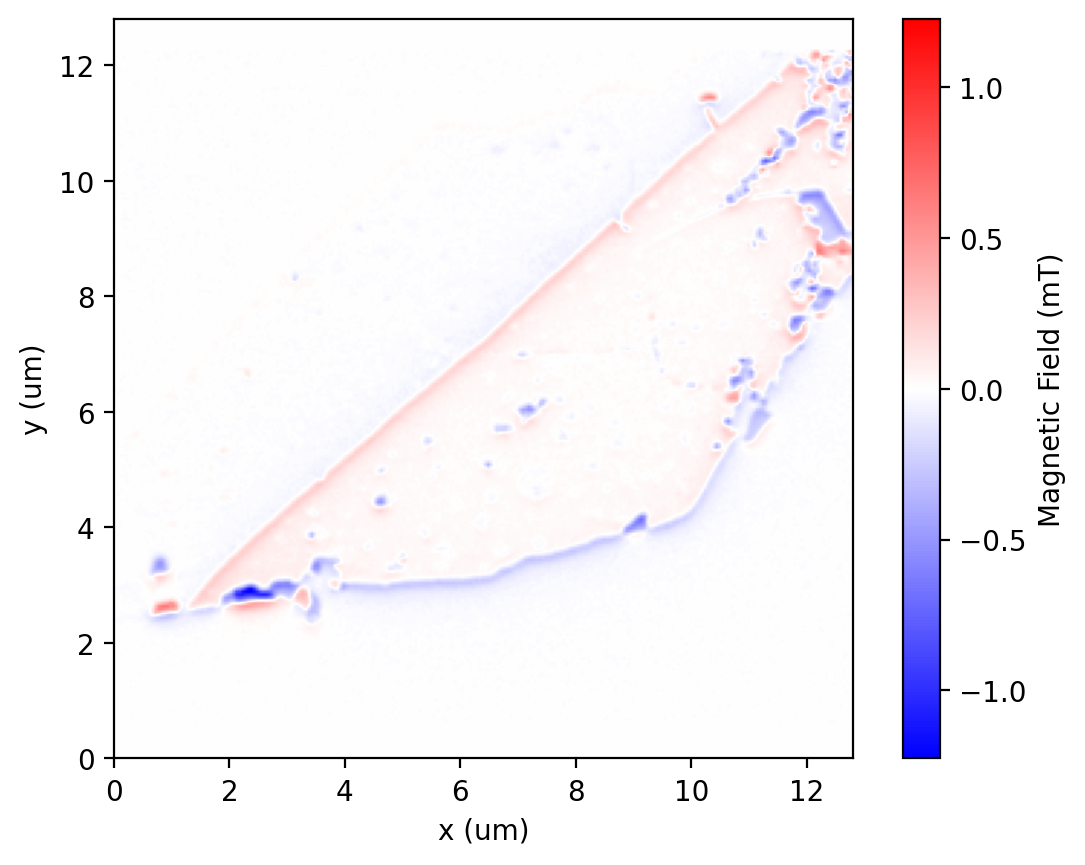

In [6]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

# Transfor Bsensor into Bxyz

c:\Users\parax\Dropbox\Programming\Python\magrec\magrec\notebooks\../..\magrec\misc\plot.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  datum = np.float64(data[i // n_components][i % n_components]).T  # convert to float64 to avoid an issue with matplotlib and casting


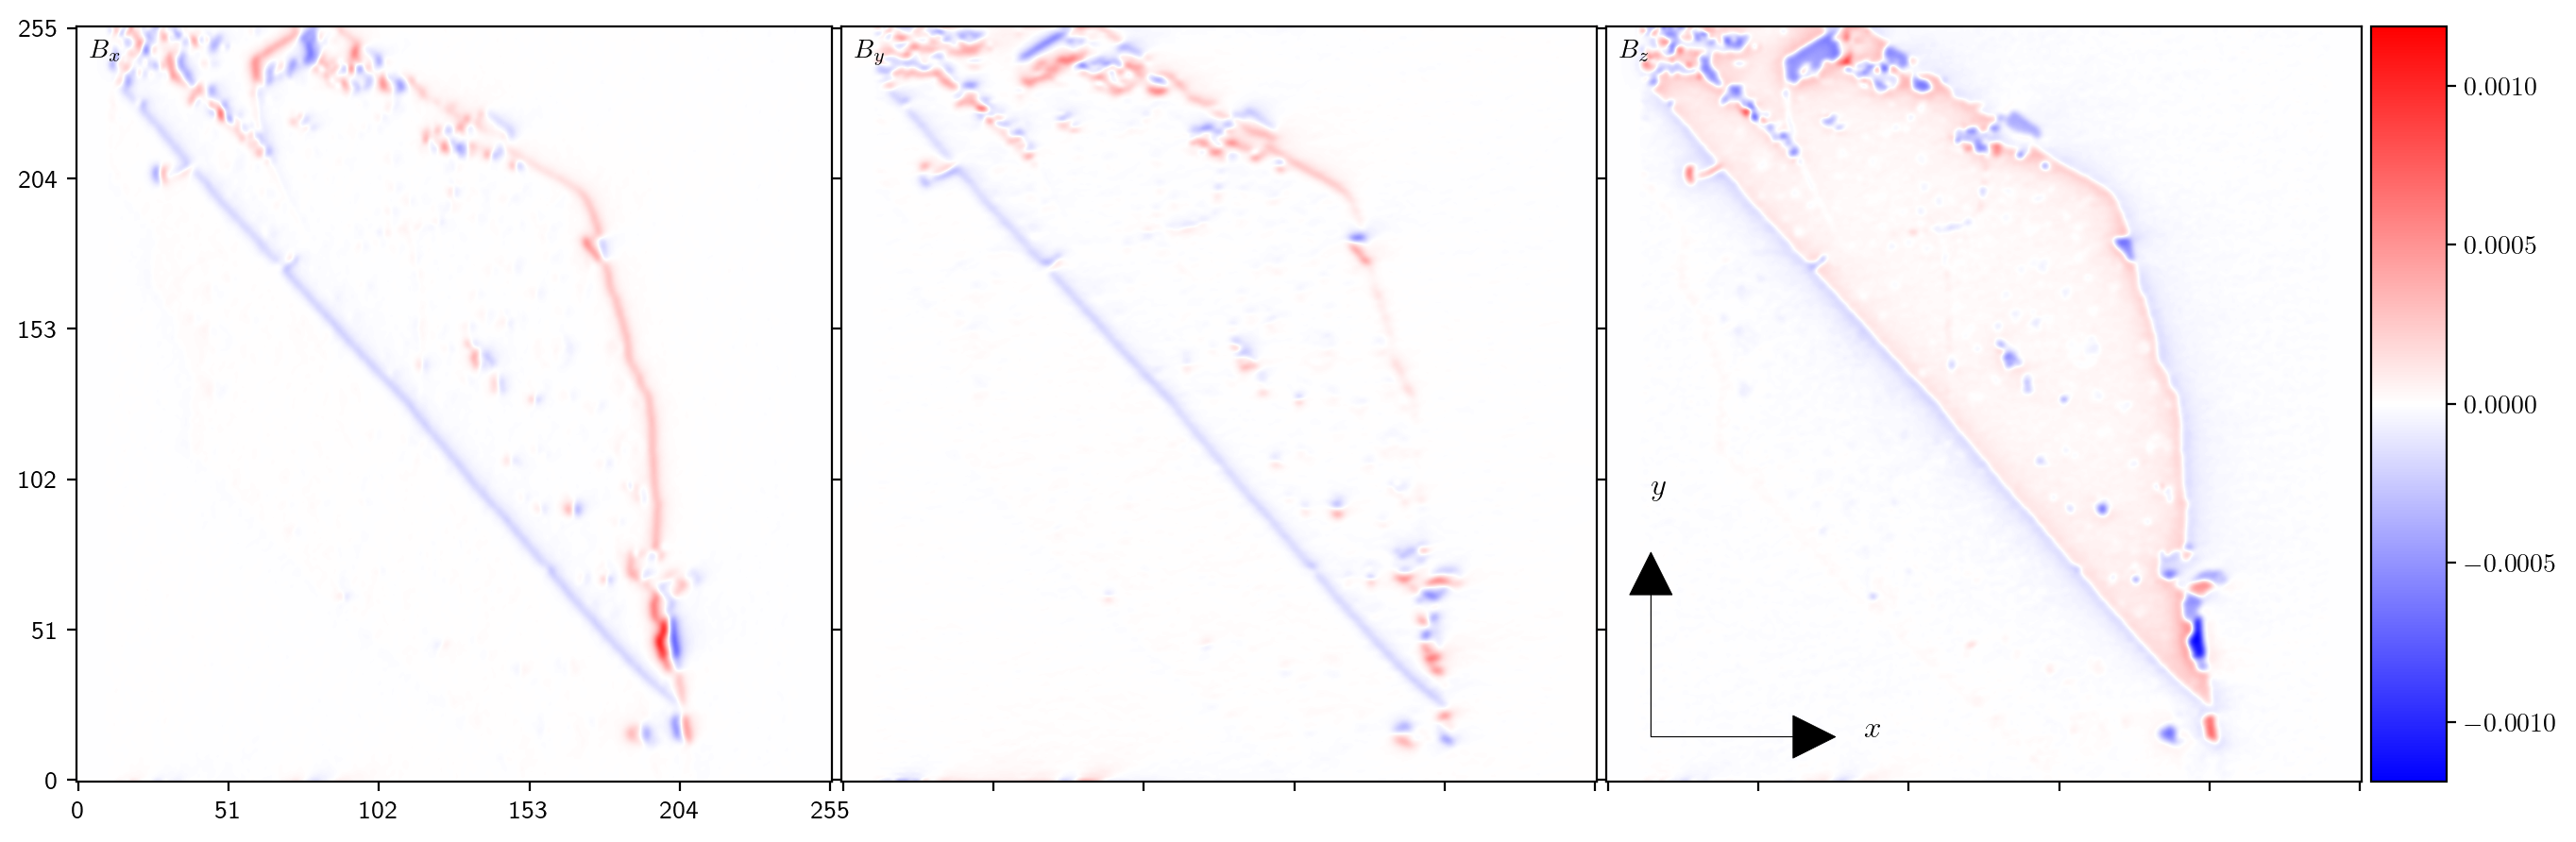

In [7]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Now we will try to reconstruct the magnetisation using a neural network.

In [8]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

dataset4 = copy.deepcopy(dataset)
dataset4.target = dataset4.target

Model = UniformMagnetisation(dataset4, 
                             loss_type = "MSE", 
                             scaling_factor = 1e12, 
                             m_theta = 0, 
                             m_phi = 0, 
                             source_weight = None,
                             loss_weight = None,  )
FittingMethod = FCNN(Model)


Number of sources: 1
Number of targets: 1
Including source angles in the neural network: False


In [9]:
FittingMethod.fit(n_epochs=300)

epoch     1 | loss on last mini-batch:  4.18e+15
epoch    26 | loss on last mini-batch:  4.16e+15
epoch    51 | loss on last mini-batch:  4.07e+15
epoch    76 | loss on last mini-batch:  3.88e+15
epoch   101 | loss on last mini-batch:  3.68e+15
epoch   126 | loss on last mini-batch:  3.53e+15
epoch   151 | loss on last mini-batch:  3.40e+15
epoch   176 | loss on last mini-batch:  3.32e+15
epoch   201 | loss on last mini-batch:  3.18e+15
epoch   226 | loss on last mini-batch:  3.21e+15
epoch   251 | loss on last mini-batch:  3.04e+15
epoch   276 | loss on last mini-batch:  3.18e+15


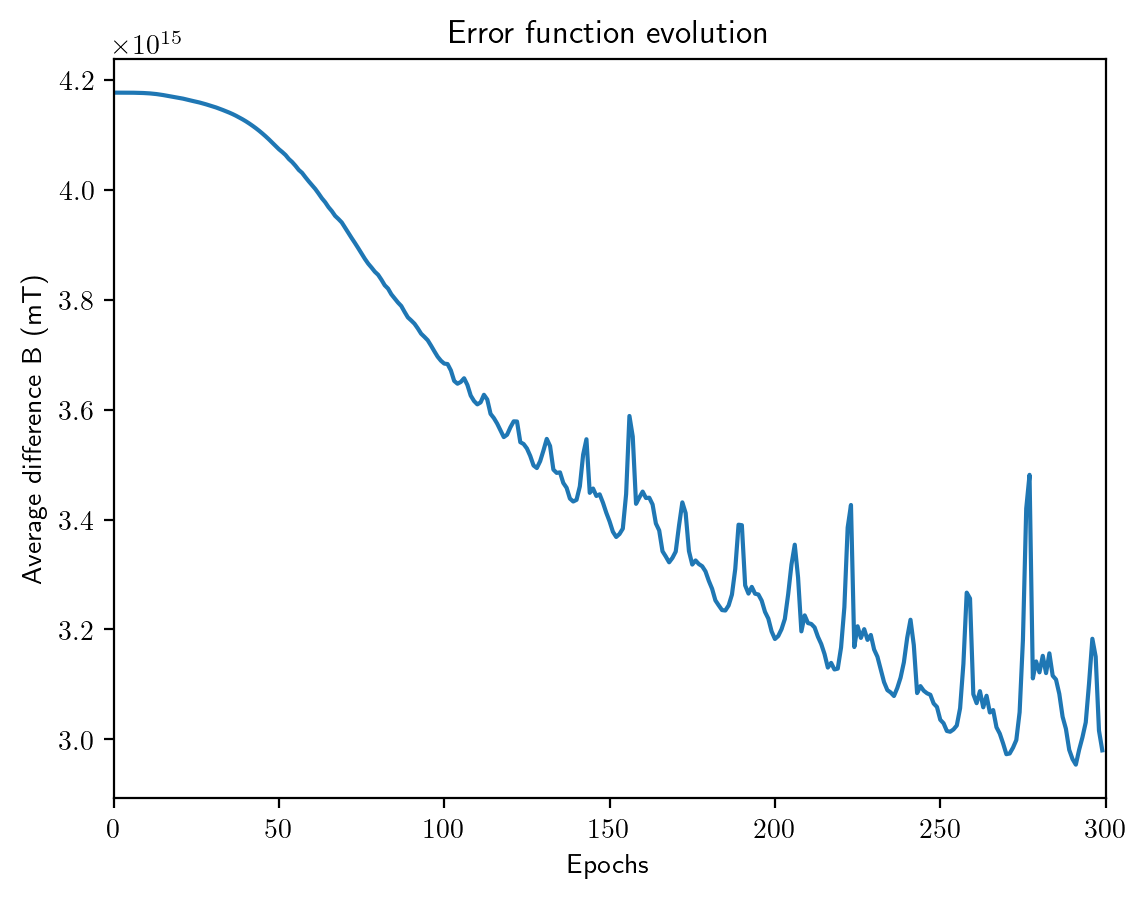

In [10]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


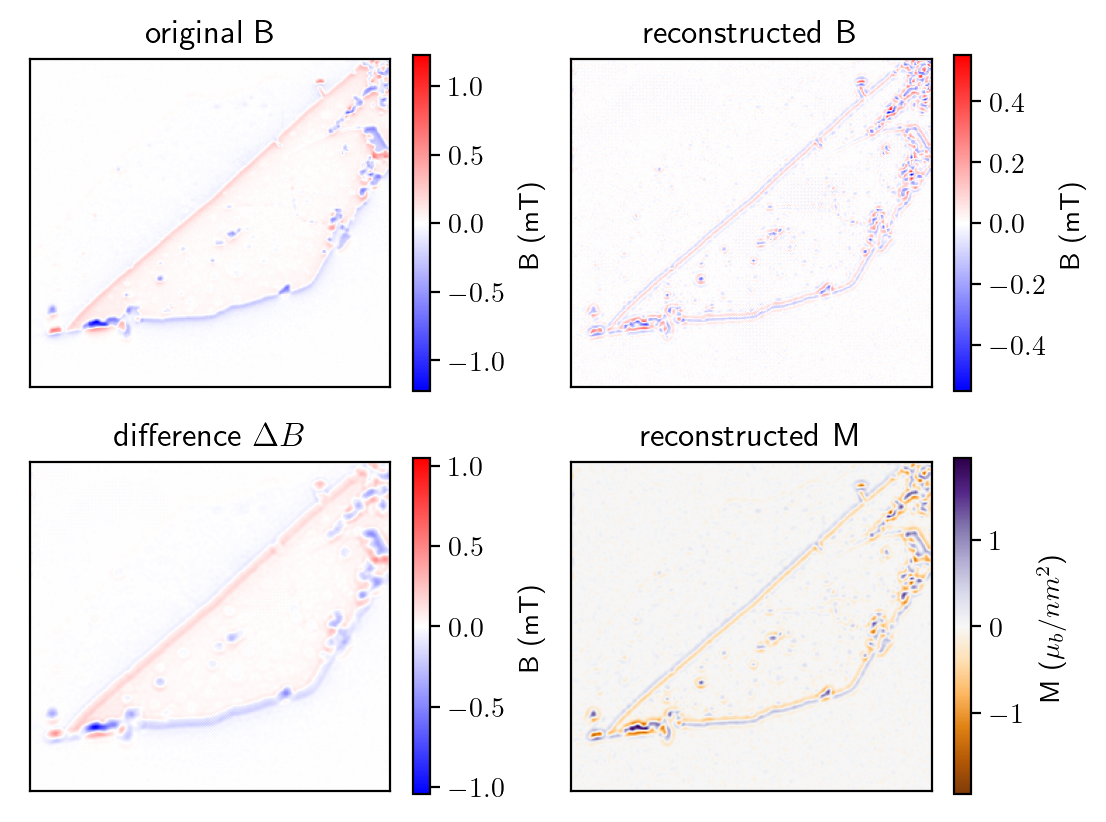

In [11]:
# FittingMethod.extract_results()
FittingMethod.plot_results()